In [20]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from variable_names import to_keep
import missingno as msno
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix


from sklearn.linear_model import LinearRegression, LogisticRegression

# eye candy plots
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
# source https://github.com/dhaitz/matplotlib-stylesheets


from preprocessing_pipeline import test_train_time_split, make_pipeline, convert_labels

In [4]:
### Here we make some arguments about why we drop certain variables

## Fill in later


In [5]:
### Import the data

df = pd.read_csv('data/Train.csv')
df = df[to_keep]

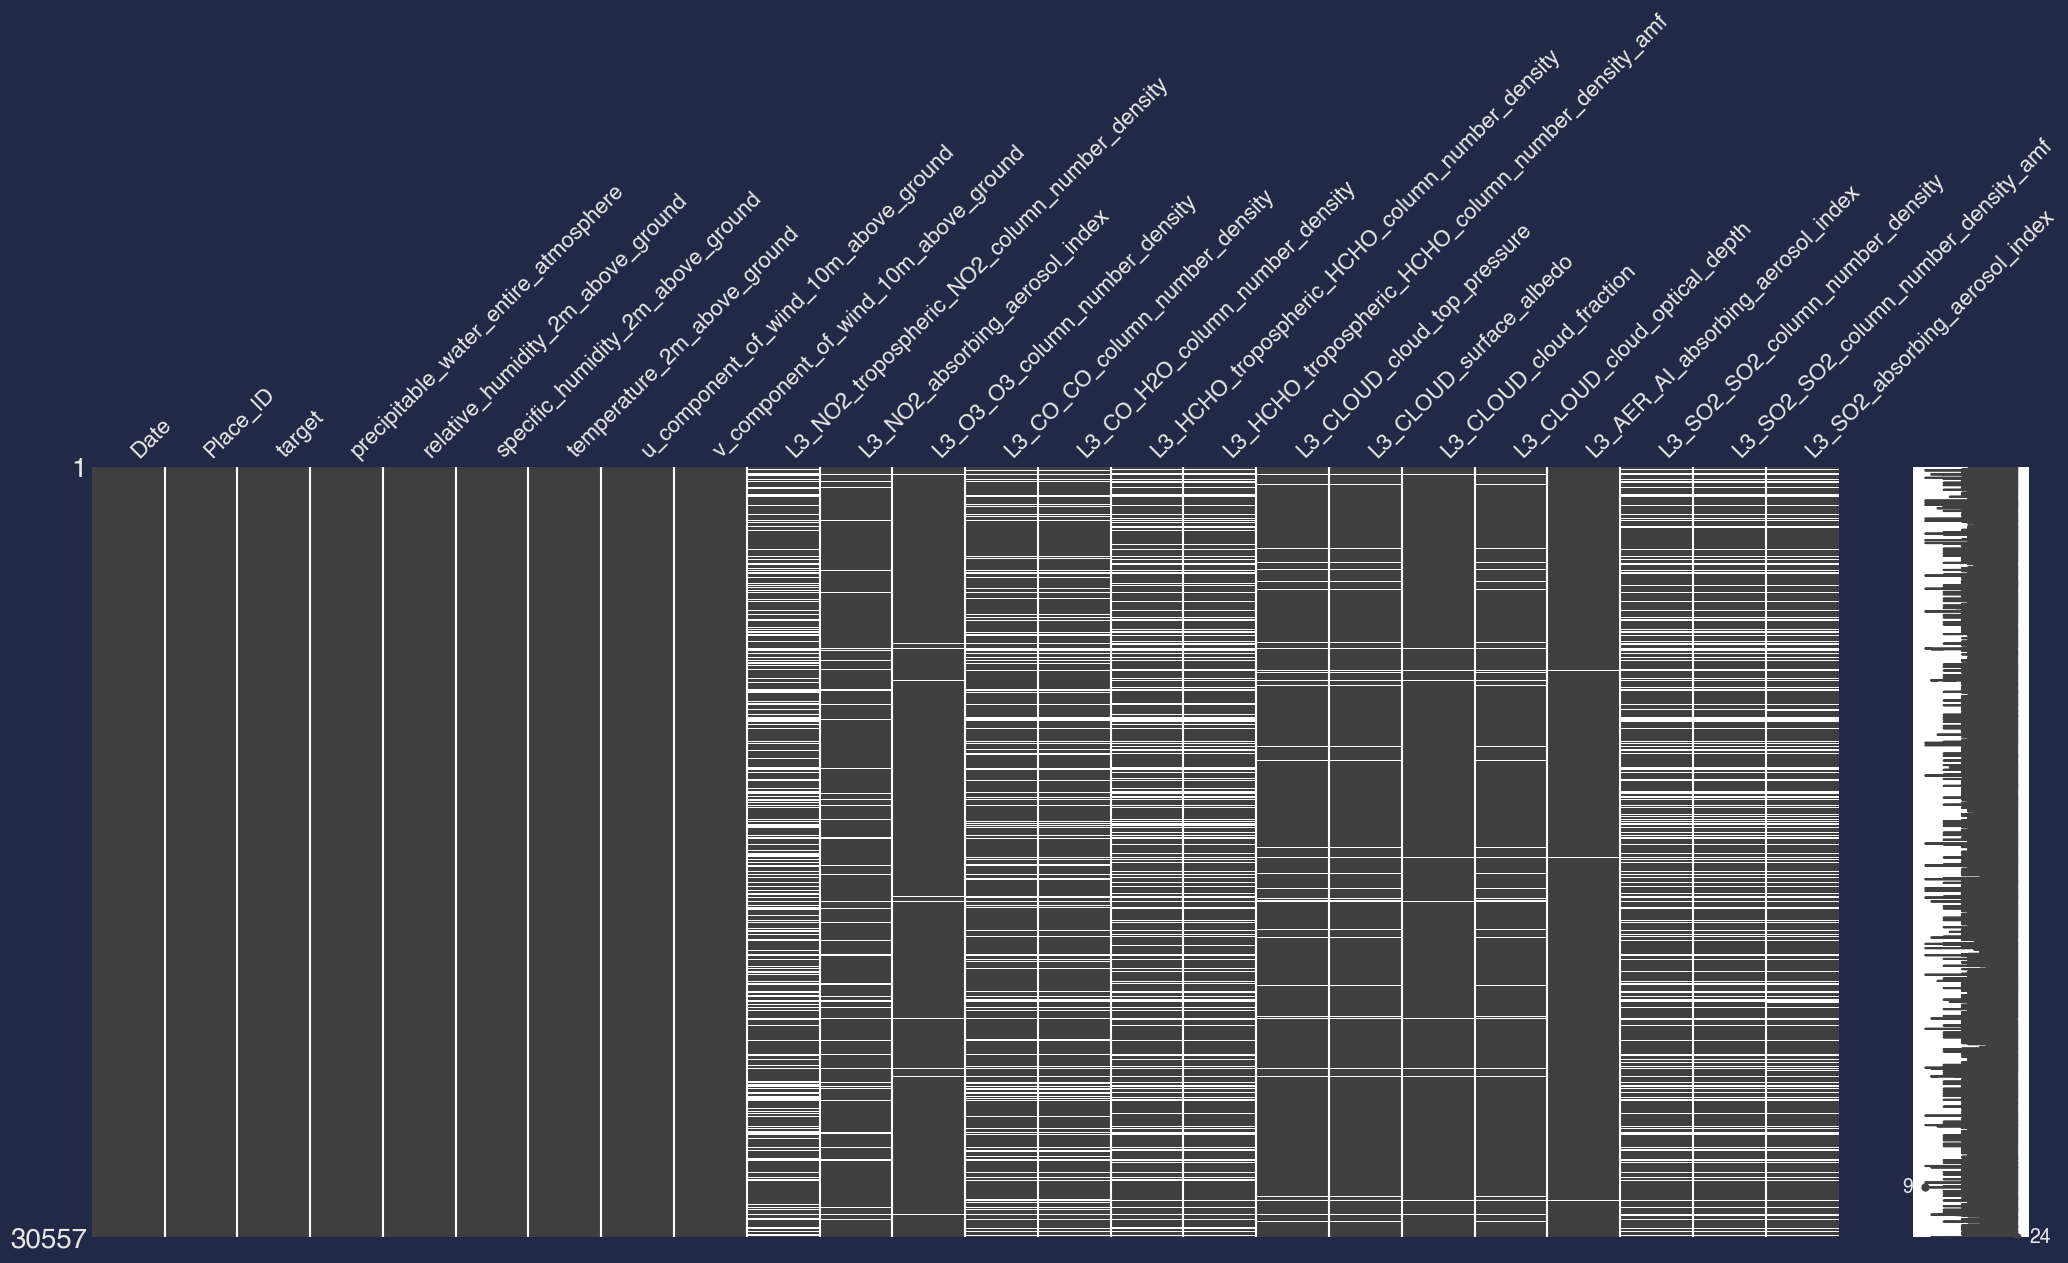

In [6]:
## How are the missingo numbers distributed?
msno.matrix(df);

In [7]:
## Drop rows with less than 15 non-NaN points

df.dropna(thresh=15, inplace=True)

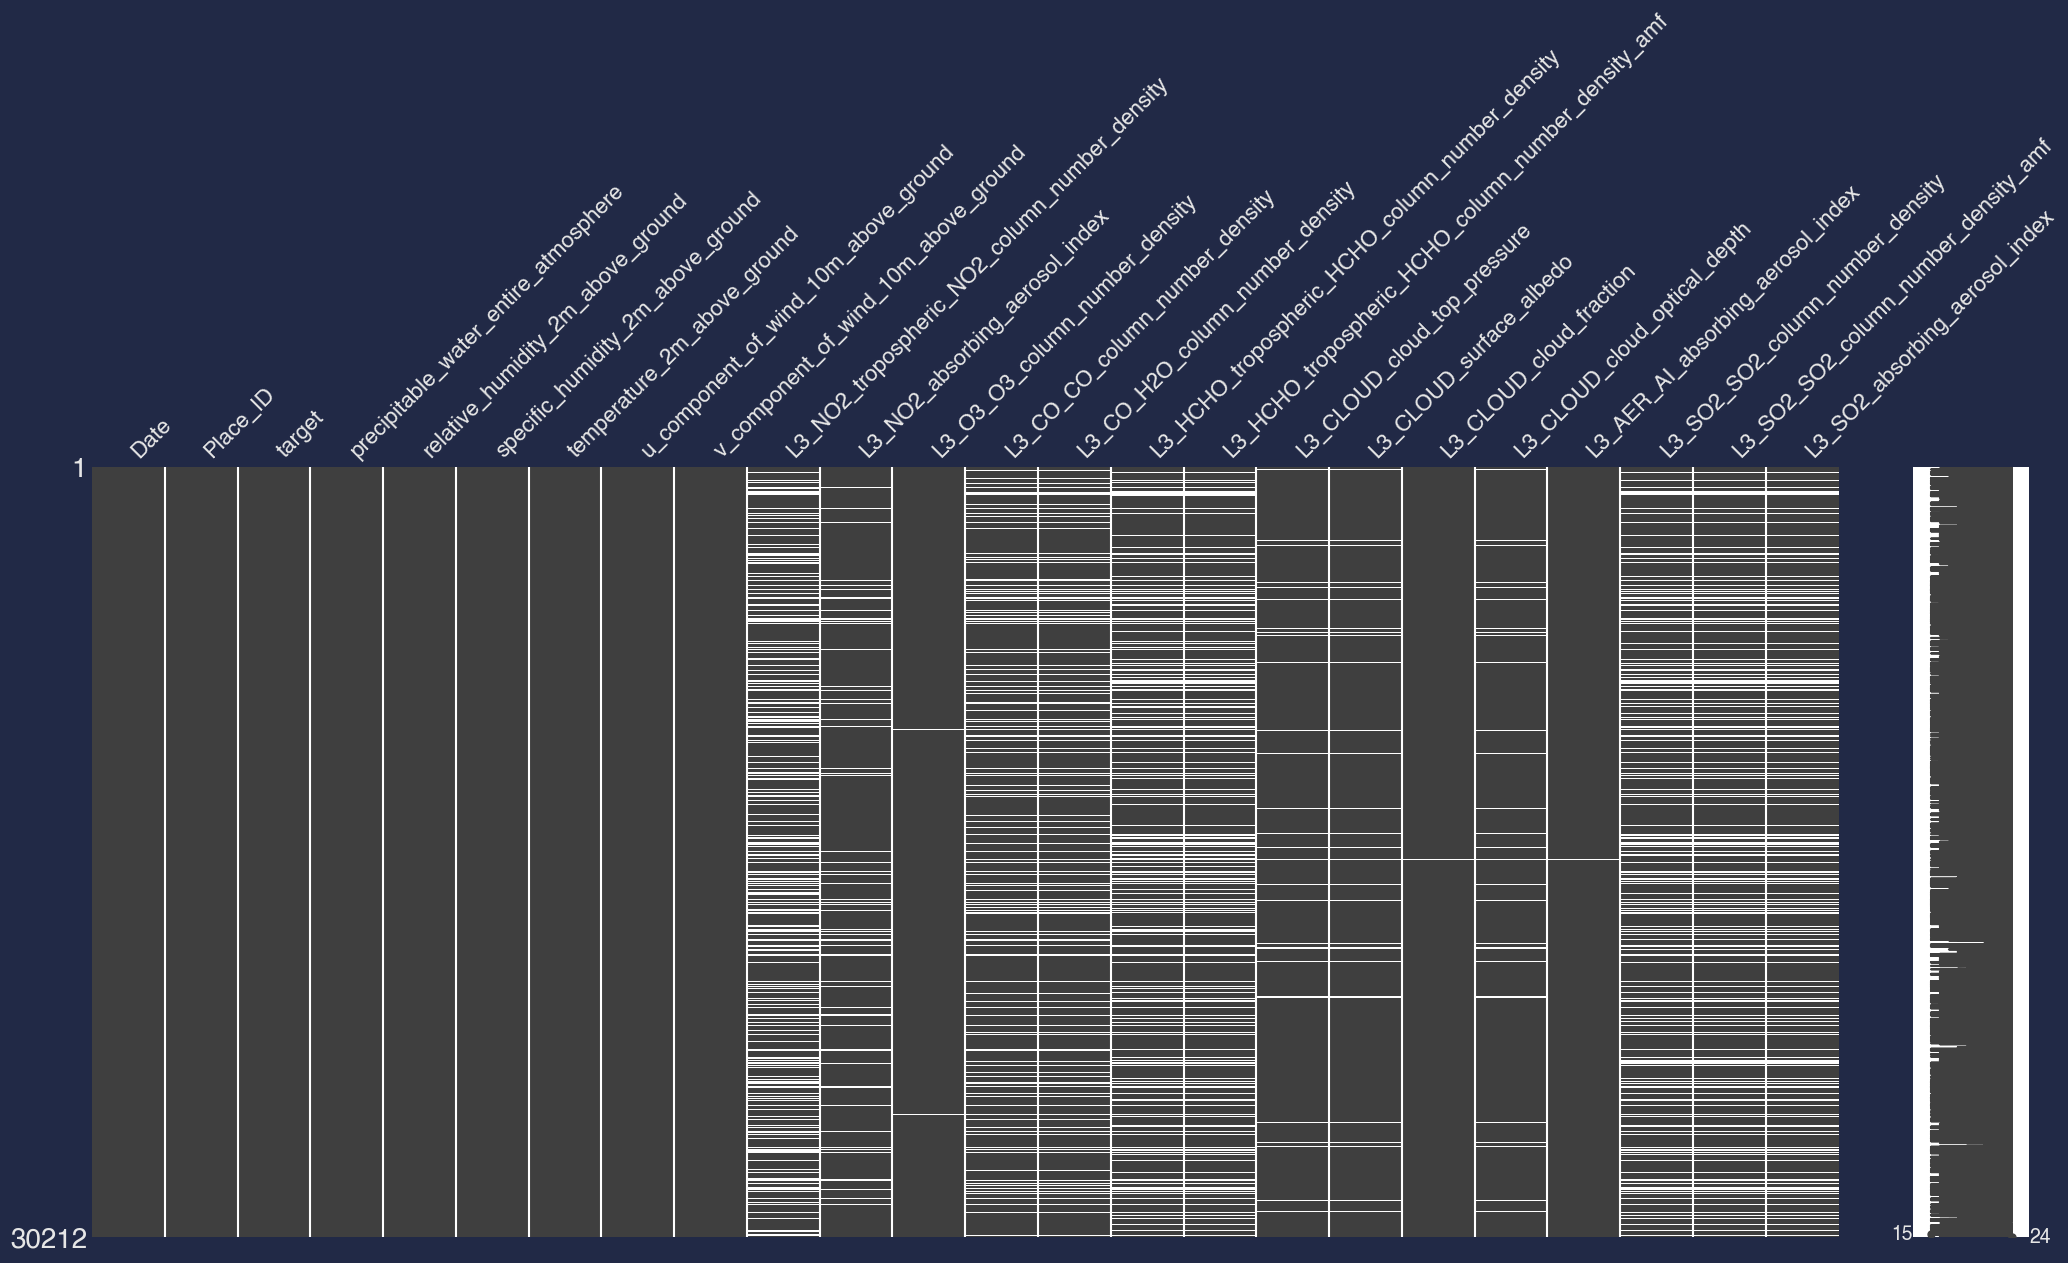

In [8]:
msno.matrix(df);

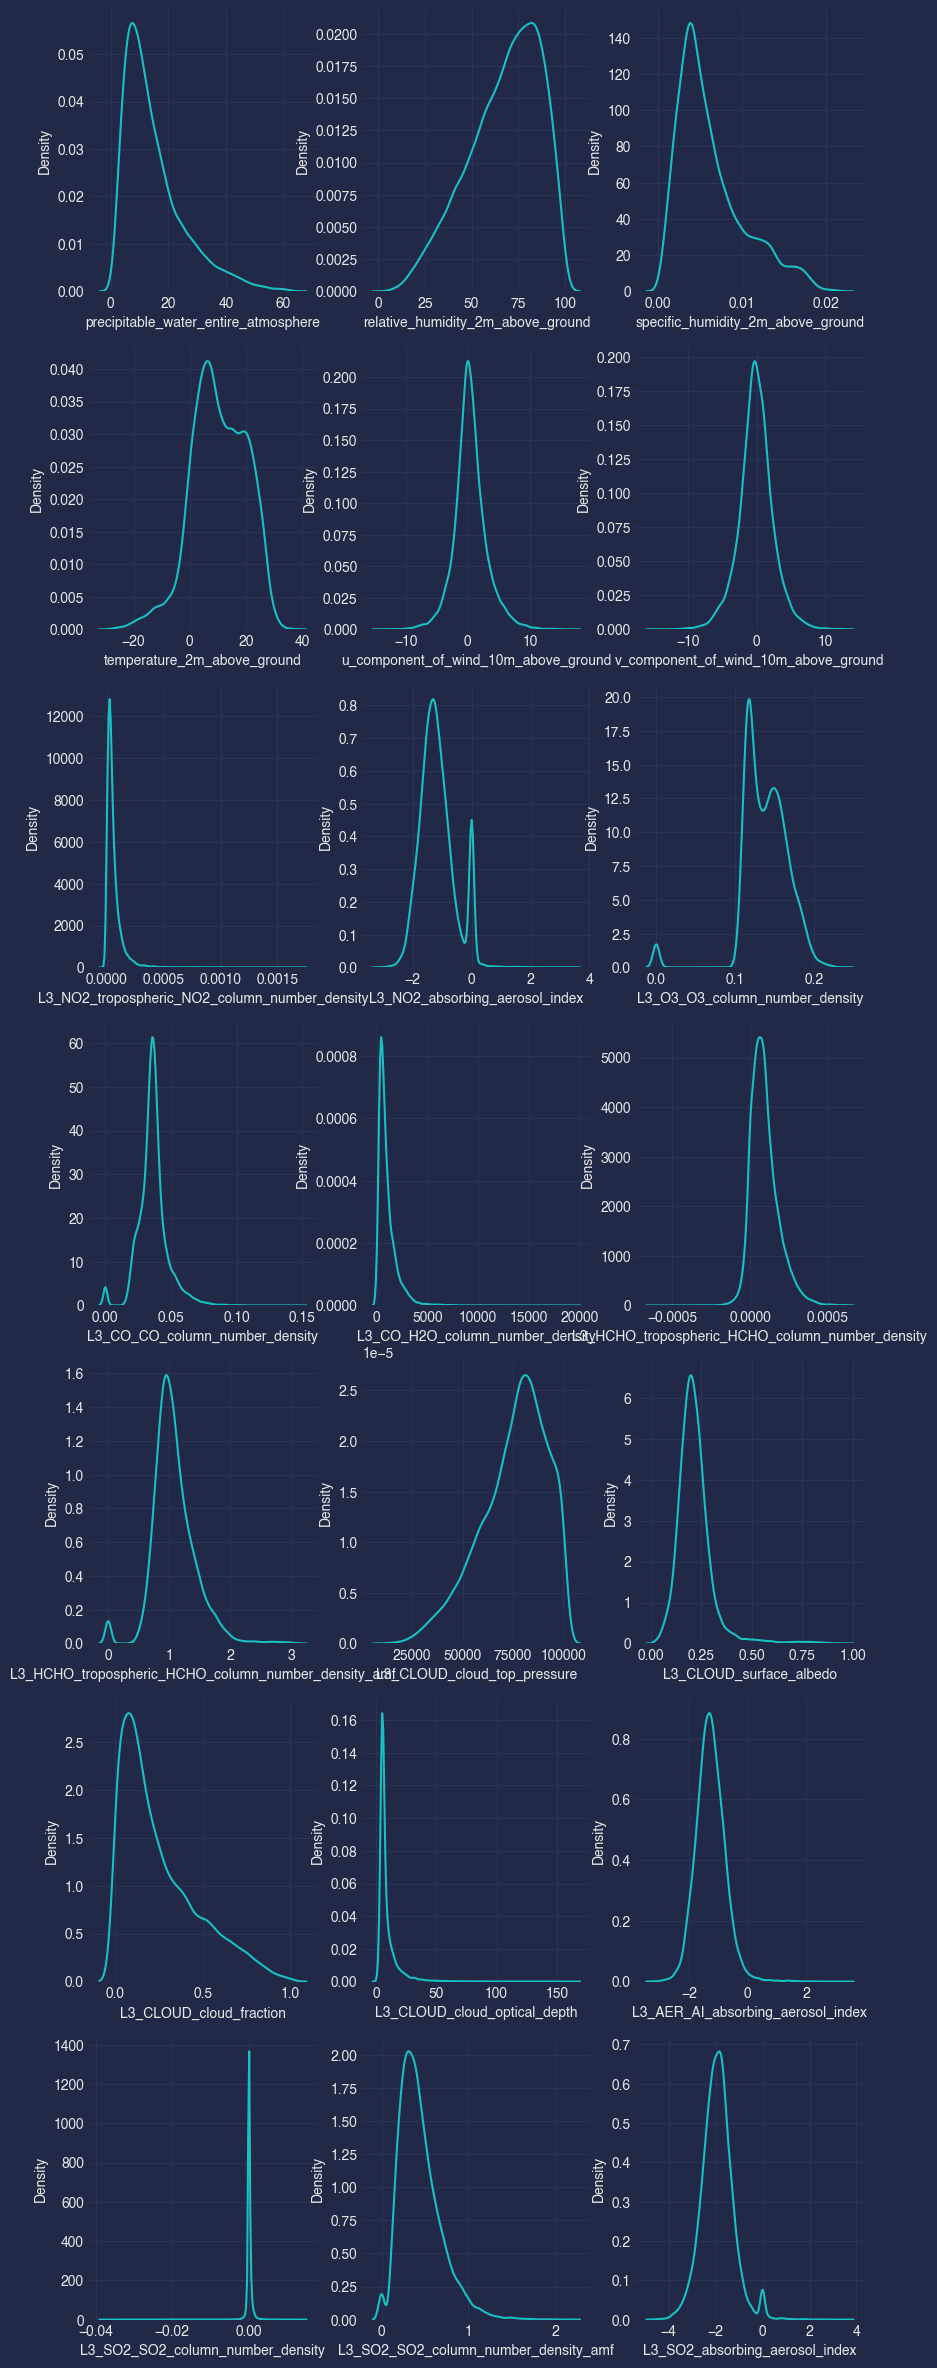

In [9]:
vars_tokeep = df.columns.to_list()

for item in ['Date','Place_ID','target']:
    vars_tokeep.remove(item)



fig, ax = plt.subplots(7,3, figsize=(10,30))


for var,axi in zip(vars_tokeep, ax.ravel()):
    sns.kdeplot(data= df.dropna(how='any'), x = var, ax=axi);

plt.show()

## Test train split for time-series data

In [10]:
#Perform test train split for time series data
X_train, X_test, y_train, y_test = test_train_time_split(data=df,
                                                         target_name='target',
                                                         date_name='Date',
                                                         test_size=0.3)

X_train = X_train.drop(['Date'],axis=1)
X_test = X_test.drop(['Date'],axis=1)

X_train_nl = X_train.drop(['Place_ID'],axis=1)
X_test_nl = X_test.drop(['Place_ID'],axis=1)


In [11]:
X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(df.drop(['Date','target'], axis=1), df['target'],
                                                                test_size=0.3)

#### Data Preprocessing Pipeline, without standardisation

In [12]:
qnt_cols = [col for col in to_keep if col not in ['Place_ID','Date','target']]
cat_cols = ['Place_ID']

preprocessor = make_pipeline(qnt_cols,cat_cols)
# X_train = preprocessor.fit_transform(X_train)
# X_test = preprocessor.transform(X_test)

### Baseline with test train split by time

In [13]:
###
base_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('lin_reg', LinearRegression(n_jobs=-1))
])

print(f'r2 train: {np.mean(cross_val_score(base_lr, X_train, y_train, cv=5)):.2f}')

base_lr.fit(X_train, y_train)
y_pred_base = base_lr.predict(X_test)

rmse_base = mean_squared_error(y_test,y_pred_base,squared=False)
r2_base = r2_score(y_test,y_pred_base)
print(f'rmse base: {rmse_base:.2f}')
print(f'r2 test: {r2_base:.3f}')


r2 train: 0.64
rmse base: 27.65
r2 test: 0.406


### Baseline random data shuffle

In [14]:
###
base_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('lin_reg', LinearRegression(n_jobs=-1))
])

print(f'r2 train: {np.mean(cross_val_score(base_lr, X_train_nd, y_train_nd, cv=5)):.2f}')

base_lr.fit(X_train_nd, y_train_nd)
y_pred_base_nd = base_lr.predict(X_test_nd)

rmse_base = mean_squared_error(y_test_nd,y_pred_base_nd,squared=False)
r2_base = r2_score(y_test_nd,y_pred_base_nd)
print(f'rmse base: {rmse_base:.2f}')
print(f'r2 test: {r2_base:.3f}')


r2 train: 0.66
rmse base: 26.88
r2 test: 0.667


### Baseline, no location, with split by time

In [15]:
preprocessor_noloc = make_pipeline(qnt_cols,None)

###
base_lr = Pipeline([
    ('preprocessor', preprocessor_noloc),
    ('lin_reg', LinearRegression(n_jobs=-1))
])

print(f'r2 train: {np.mean(cross_val_score(base_lr, X_train_nl, y_train, cv=5)):.2f}')

base_lr.fit(X_train_nl, y_train)
y_pred_base_nl = base_lr.predict(X_test_nl)

rmse_base = mean_squared_error(y_test,y_pred_base_nl,squared=False)
r2_base = r2_score(y_test,y_pred_base_nl)
print(f'rmse base: {rmse_base:.2f}')
print(f'r2 test: {r2_base:.3f}')



r2 train: 0.29
rmse base: 35.57
r2 test: 0.016


In [16]:
### Histograms for months?
## One day prior? as feature! temperature, windspeed, precipitable water...



In [43]:
## Later I want to do a fillna with local mean based on Place_ID

y_train_lb = convert_labels(y_train,bins=[0,25,50,np.inf])
y_test_lb = convert_labels(y_test,bins=[0,25,50,np.inf])

In [44]:
###
base_log = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression(n_jobs=-1,max_iter=1000))
])

base_log.fit(X_train, y_train_lb);
y_pred_base_lb = base_log.predict(X_test);



print(f'train f1: {np.mean(cross_val_score(base_log, X_train, y_train_lb, cv=5)):.2f}')
print(classification_report(y_test_lb,y_pred_base_lb))
print(confusion_matrix(y_test_lb,y_pred_base_lb))

train f1: 0.73
              precision    recall  f1-score   support

           0       0.61      0.72      0.66      2246
           1       0.49      0.32      0.39      2374
           2       0.77      0.84      0.80      4443

    accuracy                           0.68      9063
   macro avg       0.62      0.63      0.62      9063
weighted avg       0.66      0.68      0.66      9063

[[1623  385  238]
 [ 723  755  896]
 [ 295  402 3746]]


In [36]:
pd.cut(y_train,bins=[0,25,50,100,np.inf],labels=False, include_lowest=True).sort_values().value_counts()

2    6710
0    5297
1    5189
3    3953
Name: target, dtype: int64